In [36]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from astropy.io import fits
import easydarkfigs
import pcmdpy as ppy
from numpy.linalg import eig, inv
%matplotlib inline

In [43]:
def get_XY(image):
    ny, nx = image.shape
    Y, X = np.mgrid[:ny, :nx]
    return X, Y

In [68]:
def get_RTheta(image, xc=0, yc=0):
    X, Y = get_XY(image)
    X = X - xc
    Y = Y - yc
    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(Y, X)
    return R, Theta

# NGC 4993

In [3]:
f = ppy.instrument.default_ngc4993_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)

In [6]:
with fits.open('../data/NGC4993/reduced/NGC4993_F850LP_drc.fits') as h:
    f850lp = f[0].counts_to_mag(h['SCI'].data)
    regions = h['REGIONS'].data
with fits.open('../data/NGC4993/reduced/NGC4993_F475W_drc.fits') as h:
    f475w = f[1].counts_to_mag(h['SCI'].data)

In [8]:
mags = f850lp
colors = f475w - f850lp

In [30]:
def plot_mags(mask, ax=None):
    im = np.zeros_like(mags) + 1000.
    data = mags[mask]
    im[mask] = data
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.imshow(im, norm=mpl.colors.Normalize(vmin=np.percentile(data, 1), vmax=np.percentile(data, 99)), cmap='viridis_r')
    ys, xs = np.where(mask)
    ax.set_xlim([xs.min(), xs.max()])
    ax.set_ylim([ys.min(), ys.max()])
    plt.colorbar()
    return ax

In [33]:
def plot_colors(mask, ax=None):
    im = np.zeros_like(colors)
    data = colors[mask]
    im[mask] = data
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.imshow(im, norm=mpl.colors.Normalize(vmin=np.percentile(data, 1), vmax=np.percentile(data, 99)))
    ys, xs = np.where(mask)
    ax.set_xlim([xs.min(), xs.max()])
    ax.set_ylim([ys.min(), ys.max()])
    plt.colorbar(ax=ax)
    return ax

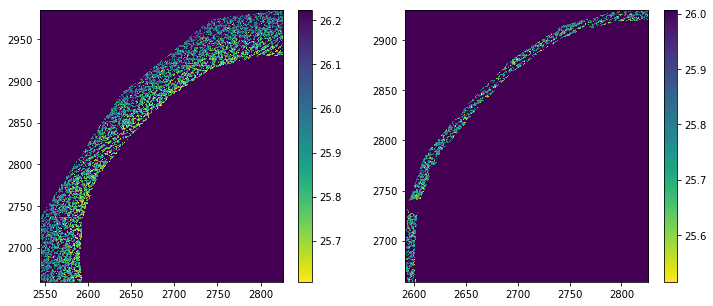

In [35]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
plot_mags((regions == 70), ax=axes[0])
plot_mags((regions == 74), ax=axes[1])

http://nicky.vanforeest.com/misc/fitEllipse/fitEllipse.html

In [130]:
# def fitEllipse(x,y):
#     """
#     Given arrays of x's and y's, return an Elliptical fit to the points
#     """
#     x = x[:,np.newaxis]
#     y = y[:,np.newaxis]
#     D =  np.hstack((x*x, x*y, y*y, x, y, np.ones_like(x)))
#     S = np.dot(D.T,D)
#     C = np.zeros([6,6])
#     C[0,2] = C[2,0] = 2; C[1,1] = -1
#     E, V =  eig(np.dot(inv(S), C))
#     n = np.argmax(np.abs(E))
#     a = V[:,n]
#     return a

# def ellipse_center(a):
#     b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
#     num = b*b-a*c
#     x0=(c*d-b*f)/num
#     y0=(a*f-b*d)/num
#     return np.array([x0,y0])


# def ellipse_angle_of_rotation( a ):
#     b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
#     if b == 0:
#         if a > c:
#             return 0
#         else:
#             return np.pi/2
#     else:
#         if a > c:
#             return np.arctan(2*b/(a-c))/2
#         else:
#             return np.pi/2 + np.arctan(2*b/(a-c))/2

# def ellipse_axis_length( a ):
#     b,c,d,f,g,a = a[1]/2, a[2], a[3]/2, a[4]/2, a[5], a[0]
#     up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
#     down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
#     down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
#     res1=np.sqrt(up/down1)
#     res2=np.sqrt(up/down2)
#     return np.array([res1, res2])

# def getEllipseParams(x, y):
#     """
#     Given arrays of x's and y's, return the elliptical parameters
#     """
#     a = fitEllipse(x, y)
#     center = ellipse_center(a)
#     phi = ellipse_angle_of_rotation(a)
#     b, a = ellipse_axis_length(a)
#     if (phi < 0.) & (a < b):
#         phi += np.pi
#         b, a = a, b
#     if (phi <= np.pi/2.) & (b < a):
#         phi = np.pi - phi
# #         b, a = a,b
#     r = np.sqrt(a**2 + b**2)
#     a /= r
#     b /= r
#     return center[0], center[1], a, b, r, phi

In [122]:
def correct_angle(theta):
    if isinstance(theta, float):
        if theta <= -np.pi:
            return theta + 2*np.pi
        elif theta >= np.pi:
            return theta - 2*np.pi
        else:
            return theta
    else:
        theta[theta <= -np.pi] += 2*np.pi
        theta[theta >= np.pi] -= 2*np.pi
    return theta

In [123]:
def is_between(thetas, lower, upper):
    lower, upper = correct_angle(np.array([lower, upper]))
    if lower <= upper:
        return (lower <= thetas) & (thetas <= upper)
    else:  # if upper loops around
        return (upper <= thetas) & (thetas <= lower)

In [127]:
def getEllipseParamsManual(mask, xc=0, yc=0, dtheta=0.05):
    R, Theta = get_RTheta(mask, xc=xc, yc=yc)
    R = R[mask]
    Theta = Theta[mask]
    b = R.min()
    Theta_min = Theta[R.argmin()]
    t1, t2 = correct_angle(np.array([-dtheta, dtheta]) + Theta_min - np.pi/2)
    t3, t4 = correct_angle(np.array([-dtheta, dtheta]) + Theta_min + np.pi/2)
    far_mask_1 = is_between(Theta, t1, t2)
    far_mask_2 = is_between(Theta, t3, t4)
    a = 0.5 * (R[far_mask_1].min() + R[far_mask_2].min())
    Theta_max = correct_angle(Theta_min + np.pi/2.)
    r = np.sqrt(a**2 + b**2)
    phi = Theta_max
    return xc, yc, a/r, b/r, r, phi

In [131]:
def plot_ellipse(mask, ax=None, xc=0, yc=0):
    cx, cy, a, b, r, phi = getEllipseParamsManual(mask, xc=xc, yc=yc)
    if ax is None:
        fig, ax = plt.subplots()
    R = np.arange(0, 2*np.pi, 0.01)
    t1, t2 = a*r, b*r
    xx = cx + t1*np.cos(R)*np.cos(phi) - t2*np.sin(R)*np.sin(phi)
    yy = cy + t1*np.cos(R)*np.sin(phi) + t2*np.sin(R)*np.cos(phi)
    ax.plot(xx, yy, 'r:')
    x0 = cx + t1*np.cos(phi)
    y0 = cy + t1*np.sin(phi)
    ax.plot(x0, y0, 'ro', ms=20)
    return ax

In [138]:
def transform_r_theta(mask, xc=0, yc=0):
    Xs, Ys = get_XY(mask)
    X, Y = Xs[mask], Ys[mask]
    cx, cy, a, b, r, phi = getEllipseParamsManual(mask, xc=xc, yc=yc)
    X_ = (X - cx)
    Y_ = (Y - cy)
    X_rot = X_*np.cos(-phi) - Y_*np.sin(-phi)
    Y_rot = Y_*np.cos(-phi) + X_*np.sin(-phi)
    r = np.sqrt((X_rot / a)**2 + (Y_rot / b)**2)
    theta = np.arctan2(Y_rot/b, X_rot/a)
    return r, theta

In [134]:
def plot_radii(mask, ax=None, xc=None, yc=None):
    Xs, Ys = get_XY(mask)
    rs, thetas = get_r_theta(mask, xc=xc, yc=yc)
    im = np.zeros_like(Xs, dtype=float)
    im[mask] = rs
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.imshow(im, norm=mpl.colors.Normalize(vmin=rs.min(), vmax=rs.max()))
    ys, xs = np.where(mask)
    ax.set_xlim([xs.min(), xs.max()])
    ax.set_ylim([ys.min(), ys.max()])
    plt.colorbar()
    return ax

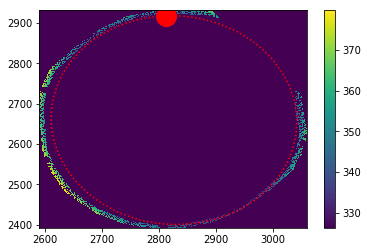

In [137]:
mask = (regions >= 73)&(regions < 77)
ax = plot_radii(mask, xc=2827, yc=2659)
plot_ellipse(mask, ax=ax, xc=2827, yc=2659)

In [139]:
R, theta = transform_r_theta(mask, xc=2827, yc=2659)

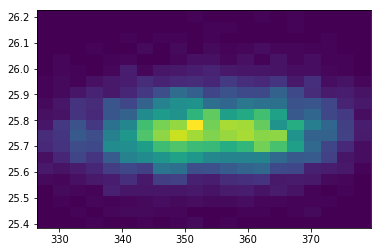

In [142]:
plt.hist2d(R, mags[mask], bins=20);

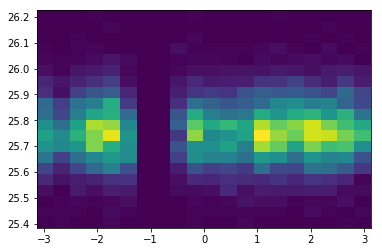

In [143]:
plt.hist2d(theta, mags[mask], bins=20);